In [31]:
import pandas as pd
import re
import sqlparse

db = "cockroachdb"
db1 = "duckdb"
db2 = "sqlite"
db3 = "mysql"

results_df_cockroach = pd.read_csv(f"{db}_output/{db}_results.csv")
results_df_duck = pd.read_csv(f"{db1}_output/{db1}_results.csv")
results_df2_sqlite = pd.read_csv(f"{db2}_output/{db2}_results.csv")
results_df3_mysql = pd.read_csv(f"{db3}_output/{db3}_results.csv_debug")

In [12]:
testcase_mapping = results_df_cockroach[['TESTFILE_INDEX', 'TESTFILE_PATH']].drop_duplicates()
#results_df_cockroach = results_df_cockroach.set_index(['TESTFILE_INDEX','TESTCASE_INDEX'])
#results_df_duck = results_df_duck.set_index(['TESTFILE_INDEX','TESTCASE_INDEX'])
#results_df2_sqlite = results_df2_sqlite.set_index(['TESTFILE_INDEX','TESTCASE_INDEX'])
#results_df3_mysql =results_df3_mysql.set_index(['TESTFILE_INDEX','TESTCASE_INDEX'])
drop_cockroach_errors = results_df_cockroach[results_df_cockroach.IS_ERROR == True].index

In [13]:
cockroach = results_df_cockroach.drop(['Unnamed: 0','ORIGINAL_SUITE','DATE','TESTFILE_PATH'], axis =1).copy()
#cockroach = cockroach.drop(drop_cockroach_errors)
duck = results_df_duck.drop(['Unnamed: 0','ORIGINAL_SUITE','DATE','TESTFILE_PATH'], axis =1).copy()
#duck = duck.drop(drop_cockroach_errors, errors='ignore')
sqlite = results_df2_sqlite.drop(['Unnamed: 0','ORIGINAL_SUITE','DATE','TESTFILE_PATH'], axis =1).copy()
#sqlite = sqlite.drop(drop_cockroach_errors, errors='ignore')
mysql = results_df3_mysql.drop(['Unnamed: 0','ORIGINAL_SUITE','DATE','TESTFILE_PATH'], axis =1).copy()
#mysql = mysql.drop(drop_cockroach_errors, errors='ignore')

In [14]:
cols = ['TESTCASE_INDEX','TESTFILE_INDEX','SQL','CASE_TYPE','EXPECTED_RESULT', 'USER']
dummy = 'squality_nishita_3.14159'
cockroach = cockroach.fillna(dict(zip(cols, [dummy]*len(cols))))
dfc = cockroach.drop(columns = cols).drop(columns = ['DBMS_NAME'])
dfc.columns = 'cockroachdb_' + dfc.columns
dfc = pd.concat([dfc, cockroach[cols]], axis=1)

duck = duck.fillna(dict(zip(cols, [dummy]*len(cols))))
dfduck = duck.drop(columns = cols).drop(columns = ['DBMS_NAME'])
dfduck.columns = 'duckdb_' + dfduck.columns
dfduck = pd.concat([dfduck, duck[cols]], axis=1)

sqlite = sqlite.fillna(dict(zip(cols, [dummy]*len(cols))))
dfsqlite = sqlite.drop(columns = cols).drop(columns = ['DBMS_NAME'])
dfsqlite.columns = 'sqlite_' + dfsqlite.columns
dfsqlite = pd.concat([dfsqlite, sqlite[cols]], axis=1)

mysql = mysql.fillna(dict(zip(cols, [dummy]*len(cols))))
dfmysql = mysql.drop(columns = cols).drop(columns = ['DBMS_NAME'])
dfmysql.columns = 'mysql_' + dfmysql.columns
dfmysql = pd.concat([dfmysql, mysql[cols]], axis=1)



In [15]:
df = dfc.merge(dfduck, on=cols, how='outer').merge(dfsqlite, on=cols, how='outer').merge(dfmysql, on=cols, how='outer')

In [16]:
import numpy as np
df[cols] = df[cols].replace(dummy, np.nan)

In [17]:
df = df[['TESTFILE_INDEX', 'SQL',
       'CASE_TYPE', 'EXPECTED_RESULT', 'USER','cockroachdb_ACTUAL_RESULT', 'cockroachdb_EXEC_TIME',
       'cockroachdb_IS_ERROR', 'cockroachdb_ERROR_MSG',
       'cockroachdb_LOGS_INDEX', 'duckdb_ACTUAL_RESULT',
       'duckdb_EXEC_TIME', 'duckdb_IS_ERROR', 'duckdb_ERROR_MSG',
       'duckdb_LOGS_INDEX', 'sqlite_ACTUAL_RESULT', 'sqlite_EXEC_TIME',
       'sqlite_IS_ERROR', 'sqlite_ERROR_MSG', 'sqlite_LOGS_INDEX',
       'mysql_ACTUAL_RESULT', 'mysql_EXEC_TIME', 'mysql_IS_ERROR',
       'mysql_ERROR_MSG', 'mysql_LOGS_INDEX']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12055 entries, 0 to 12054
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TESTFILE_INDEX             12055 non-null  int64  
 1   SQL                        12055 non-null  object 
 2   CASE_TYPE                  12055 non-null  object 
 3   EXPECTED_RESULT            6260 non-null   object 
 4   USER                       12055 non-null  object 
 5   cockroachdb_ACTUAL_RESULT  11621 non-null  object 
 6   cockroachdb_EXEC_TIME      12041 non-null  float64
 7   cockroachdb_IS_ERROR       12041 non-null  object 
 8   cockroachdb_ERROR_MSG      8147 non-null   object 
 9   cockroachdb_LOGS_INDEX     12041 non-null  float64
 10  duckdb_ACTUAL_RESULT       11644 non-null  object 
 11  duckdb_EXEC_TIME           11922 non-null  float64
 12  duckdb_IS_ERROR            11922 non-null  object 
 13  duckdb_ERROR_MSG           10804 non-null  obj

In [18]:
df_all_errors = df[(df['cockroachdb_IS_ERROR'] == False) & 
  (df['mysql_IS_ERROR'] == False) &
  (df['sqlite_IS_ERROR'] == False) &
  (df['duckdb_IS_ERROR'] == False)].copy()

In [19]:
df_all_errors.info()
#2214 queries pass in all databases

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2335 entries, 0 to 12040
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TESTFILE_INDEX             2335 non-null   int64  
 1   SQL                        2335 non-null   object 
 2   CASE_TYPE                  2335 non-null   object 
 3   EXPECTED_RESULT            1460 non-null   object 
 4   USER                       2335 non-null   object 
 5   cockroachdb_ACTUAL_RESULT  2290 non-null   object 
 6   cockroachdb_EXEC_TIME      2335 non-null   float64
 7   cockroachdb_IS_ERROR       2335 non-null   object 
 8   cockroachdb_ERROR_MSG      2005 non-null   object 
 9   cockroachdb_LOGS_INDEX     2335 non-null   float64
 10  duckdb_ACTUAL_RESULT       2290 non-null   object 
 11  duckdb_EXEC_TIME           2335 non-null   float64
 12  duckdb_IS_ERROR            2335 non-null   object 
 13  duckdb_ERROR_MSG           2005 non-null   obje

In [20]:
df_duck_db = df[(df['cockroachdb_IS_ERROR'] == False) & 
  (df['mysql_IS_ERROR'] == False) &
  (df['sqlite_IS_ERROR'] == False) &
  (df['duckdb_IS_ERROR'] == True)].copy()
df_duck_db_statements = df_duck_db[(df_duck_db['CASE_TYPE'] == 'Statement')].copy()
df_duck_db_queries = df_duck_db[(df_duck_db['CASE_TYPE'] == 'Query')].copy()
print("Number of statements failing in duckdb: ",len(df_duck_db_statements) )
print("Number of queries failing in duckdb: ",len(df_duck_db_queries) )

df_error = df_duck_db.copy()
print("Total number of unique error messages: ", len(df_error['duckdb_ERROR_MSG'].unique()))
value_mismatch = df_error[df_error['duckdb_ERROR_MSG'] == 'Result MisMatch']
print("Total number of result mismatch ", len(value_mismatch))



Number of statements failing in duckdb:  163
Number of queries failing in duckdb:  35
Total number of unique error messages:  48
Total number of result mismatch  7


In [21]:
df_cockroach_db = df[(df['cockroachdb_IS_ERROR'] == True) & 
  (df['mysql_IS_ERROR'] == False) &
  (df['sqlite_IS_ERROR'] == False) &
  (df['duckdb_IS_ERROR'] == False)].copy()
df_cockroach_db_statements = df_cockroach_db[(df_cockroach_db['CASE_TYPE'] == 'Statement')].copy()
df_cockroach_db_queries = df_cockroach_db[(df_cockroach_db['CASE_TYPE'] == 'Query')].copy()
print("Number of statements failing in cockroach: ",len(df_cockroach_db_statements) )
print("Number of queries failing in cockroach: ",len(df_cockroach_db_queries) )

df_error = df_cockroach_db.copy()
print("Total number of unique error messages: ", len(df_error['cockroachdb_ERROR_MSG'].unique()))
value_mismatch = df_error[df_error['cockroachdb_ERROR_MSG'] == 'Result MisMatch']
print("Total number of result mismatch ", len(value_mismatch))

testcase_mapping[testcase_mapping.TESTFILE_INDEX == 35]
df_error['cockroachdb_ERROR_MSG'].unique()

Number of statements failing in cockroach:  105
Number of queries failing in cockroach:  2
Total number of unique error messages:  2
Total number of result mismatch  2


array(['None', 'Result MisMatch'], dtype=object)

In [22]:
df_mysql_db = df[(df['cockroachdb_IS_ERROR'] == False) & 
  (df['mysql_IS_ERROR'] == True) &
  (df['sqlite_IS_ERROR'] == False) &
  (df['duckdb_IS_ERROR'] == False)].copy()
df_mysql_statements = df_mysql_db[(df_mysql_db['CASE_TYPE'] == 'Statement')].copy()
df_mysql_queries = df_mysql_db[(df_mysql_db['CASE_TYPE'] == 'Query')].copy()
print("Number of statements failing in mysql: ",len(df_mysql_statements) )
print("Number of queries failing in mysql: ",len(df_mysql_queries) )

df_error = df_mysql_db.copy()
print("Total number of unique error messages: ", len(df_error['mysql_ERROR_MSG'].unique()))
value_mismatch = df_error[df_error['mysql_ERROR_MSG'] == 'Result MisMatch']
print("Total number of result mismatch ", len(value_mismatch))




Number of statements failing in mysql:  302
Number of queries failing in mysql:  185
Total number of unique error messages:  255
Total number of result mismatch  16


In [23]:
df_sqlite_db = df[(df['cockroachdb_IS_ERROR'] == False) & 
  (df['mysql_IS_ERROR'] == False) &
  (df['sqlite_IS_ERROR'] == True) &
  (df['duckdb_IS_ERROR'] == False)].copy()
df_sqlite_statements = df_sqlite_db[(df_sqlite_db['CASE_TYPE'] == 'Statement')].copy()
df_sqlite_queries = df_sqlite_db[(df_sqlite_db['CASE_TYPE'] == 'Query')].copy()
print("Number of statements failing in sqlite: ",len(df_sqlite_statements) )
print("Number of queries failing in sqlite: ",len(df_sqlite_queries) )

df_error = df_sqlite_db.copy()
print("Total number of unique error messages: ", len(df_error['sqlite_ERROR_MSG'].unique()))
value_mismatch = df_error[df_error['sqlite_ERROR_MSG'] == 'Result MisMatch']
print("Total number of result mismatch ", len(value_mismatch))



Number of statements failing in sqlite:  141
Number of queries failing in sqlite:  40
Total number of unique error messages:  29
Total number of result mismatch  1


In [24]:
df_all_db = df[(df['cockroachdb_IS_ERROR'] == False) & 
  (df['mysql_IS_ERROR'] == False) &
  (df['sqlite_IS_ERROR'] == False) &
  (df['duckdb_IS_ERROR'] == False)].copy()
df_all_db_statement = df_all_db[(df_all_db['CASE_TYPE'] == 'Statement')].copy()
df_all_db_queries = df_all_db[(df_all_db['CASE_TYPE'] == 'Query')].copy()
print("Number of statements failing in all: ",len(df_all_db_statement) )
print("Number of queries failing in all: ",len(df_all_db_queries) )

df_error = df_all_db



Number of statements failing in all:  2005
Number of queries failing in all:  330


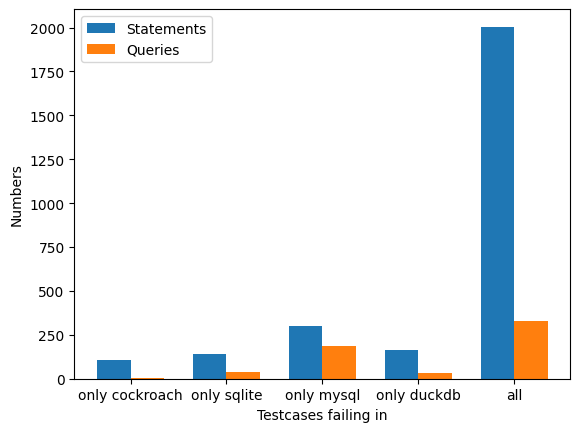

In [25]:
import matplotlib.pyplot as plt
import numpy as np

group1 = np.array([len(df_cockroach_db_statements), len(df_cockroach_db_queries)])
group2 = np.array([len(df_sqlite_statements), len(df_sqlite_queries)])
group3 = np.array([len(df_mysql_statements), len(df_mysql_queries)])
group4 = np.array([len(df_duck_db_statements), len(df_duck_db_queries)])
group5 = np.array([len(df_all_db_statement), len(df_all_db_queries)])


groups = np.concatenate((group1, group2, group3, group4, group5), axis=0).reshape((5, 2))


x = np.arange(5)
labels = np.array(['only cockroach', 'only sqlite', 'only mysql', 'only duckdb', 'all']).astype(str)

bar_width = 0.35
plt.bar(x - bar_width/2, groups[:, 0], width=bar_width, label='Statements')
plt.bar(x + bar_width/2, groups[:, 1], width=bar_width, label='Queries')

plt.xticks(x, labels)
plt.legend()
plt.xlabel('Testcases failing in')
plt.ylabel('Numbers')

plt.show()

In [313]:
def calculate_percentage_of_errors(dbms: str):
    errors = len(df[(df[f'{dbms}_IS_ERROR'] == True)])
    total_executed = len(df[~(df[f'{dbms}_EXEC_TIME']).isnull()])

    print(f"Percentage of errors in {dbms}: " , errors/total_executed * 100)
    
def calculate_percentage_of_successful_positive_testcases(dbms: str,  test_suite: str):
    success = df[(df[f'{dbms}_IS_ERROR'] == False)]
    positive_success = success[(success[f'{dbms}_ERROR_MSG'].isnull()) | (success[f'{dbms}_ERROR_MSG']=='None')]
    total_positive_testcase = len(
        df[
            ~(df[f'{dbms}_EXEC_TIME']).isnull() & 
            (df[f'{test_suite}_ERROR_MSG'].isnull()) | (df[f'{test_suite}_ERROR_MSG']=='None')
        ]
    )
    positive_success = len(positive_success)
    print(f"Percentage of success for positive test cases in {dbms}: " , positive_success/total_positive_testcase * 100)
    

calculate_percentage_of_errors("cockroachdb")
calculate_percentage_of_errors("duckdb")
calculate_percentage_of_errors("mysql")
calculate_percentage_of_errors("sqlite")

calculate_percentage_of_successful_positive_testcases("cockroachdb", "cockroachdb")
calculate_percentage_of_successful_positive_testcases("duckdb", "cockroachdb")
calculate_percentage_of_successful_positive_testcases("mysql", "cockroachdb")
calculate_percentage_of_successful_positive_testcases("sqlite", "cockroachdb")


Percentage of errors in cockroachdb:  13.370982476538492
Percentage of errors in duckdb:  64.36839456467037
Percentage of errors in mysql:  68.1190125276345
Percentage of errors in sqlite:  68.63575938850116
Percentage of success for positive test cases in cockroachdb:  97.68241295187403
Percentage of success for positive test cases in duckdb:  29.950027762354246
Percentage of success for positive test cases in mysql:  22.744874715261957
Percentage of success for positive test cases in sqlite:  23.401662049861496


In [81]:
def parse_sql(sql):
    return str(sqlparse.parse(sql)[0].token_first())  

df['sql_type'] = df.apply(lambda row: parse_sql(row['SQL']), axis=1)


In [309]:
def find_sql_not_supported_by_dbms_only(dbms: str, df_success_cockroach) :
    #find sql that have success in cockroach but failed in dbms
    df_success_cockroach_fail_dbms = df_success_cockroach[df_success_cockroach[f'{dbms}_IS_ERROR'] == True ]
    #get their unique sql types
    unique_cockroach_success_sql_types = df_success_cockroach_fail_dbms.sql_type.unique()
    #some of these sql types may have passed also, so we need to subtract them
    testcase_on_dbms_with_sql_types = df[ 
        (
            ( (df[f'{dbms}_ERROR_MSG'].isnull()) | (df[f'{dbms}_ERROR_MSG'] == 'None') ) &
            (df[f'{dbms}_IS_ERROR'] == False) & 
            (df['sql_type'].isin(unique_cockroach_success_sql_types)) 
        ) 
        ]
    sql_types = np.array(testcase_on_dbms_with_sql_types.sql_type.unique())
    sql_not_supported_by_dbms = np.setdiff1d(unique_cockroach_success_sql_types,sql_types)
    sorted_types = list(sql_not_supported_by_dbms)
    sorted_types = sorted(sorted_types, key=lambda s: len(s.split()))
    print(f"Set of SQL queries not supported by {dbms}, but supported by cockroach: ")
    print('\n'.join(sorted_types))
    print("__________________________________________________")

def find_unsupported_sql(supported_by_dbms: str):
    df_success_cockroach = df[
          ( df[f'{supported_by_dbms}_IS_ERROR'] == False) & 
          ( (df[f'{supported_by_dbms}_ERROR_MSG'].isnull()) | (df[f'{supported_by_dbms}_ERROR_MSG']=='None' )) 
            ].copy()
    unique_cockroach_success_sql_types = np.array(df_only_success_cockroach.sql_type.unique())
    #print(unique_cockroach_success_sql_types)
    find_sql_not_supported_by_dbms_only("mysql", df_success_cockroach)
    find_sql_not_supported_by_dbms_only("sqlite", df_success_cockroach)
    find_sql_not_supported_by_dbms_only("duckdb", df_success_cockroach)
    find_sql_not_supported_by_dbms_only("cockroachdb", df_success_cockroach)
    #print(f"Set of SQL queries not supported by any dbms except {supported_by_dbms}: ", unique_cockroach_success_sql_types)

find_unsupported_sql("cockroachdb")



Set of SQL queries not supported by mysql, but supported by cockroach: 
ABORT
ANALYZE
CANCEL
COMMENT
DEALLOCATE
DISCARD
END
EXECUTE
EXPLAIN
EXPLAIN(DISTSQL)
PAUSE
PREPARE
RELEASE
RESET
RESUME
UNLISTEN
UPSERT
set
DISCARD SEQUENCES
EXPERIMENTAL SCRUB
PAUSE JOBS
REASSIGN OWNED
RESUME JOBS
(((SELECT a FROM t)))
(SELECT * FROM t1)
(SELECT NULL FROM t34524)
(SELECT a FROM t1)
(SELECT j FROM t1)
VALUES ((SELECT 1)), ((SELECT 2))
VALUES (1) EXCEPT VALUES (NULL)
VALUES (1) INTERSECT VALUES (NULL)
VALUES (1), (1), (2), (3)
VALUES (NULL) EXCEPT VALUES (1)
VALUES (NULL) EXCEPT VALUES (NULL)
VALUES (NULL) INTERSECT VALUES (1)
VALUES (NULL) INTERSECT VALUES (NULL)
VALUES (1) UNION ALL VALUES (NULL)
VALUES (NULL) UNION ALL VALUES (1)
VALUES (NULL) UNION ALL VALUES (NULL)
VALUES (1, 2, 3), (4, 5, 6)
VALUES (1, 2, 1.0, 'string1'), (4, 3, 2.3, 'string2')
VALUES (length('a')), (1 + length('a')), (length('abc')), (length('ab') * 2)
(((SELECT a FROM t ORDER BY a DESC LIMIT 4)))
VALUES (1), (1), (1), (2), (